### GPU Available?

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5683868790527503063
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3865889664156746565
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17109200238616213928
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15137665216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11420266598830555648
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


### Data Pulling

In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [ ]:
#This part linkes the dataset in the drive to the google colab file
link = 'https://drive.google.com/file/d/1GEsalW5I7kD50HaBdUgUZSk1d3qBM1Z5/view?usp=sharing'
id = link.split('/')[-2]
downloaded = drive.CreateFile({'id' : id})
downloaded.GetContentFile('StockPrices.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('StockPrices.csv')
df["DailyRet"] = 0
df["20DayRet"] = 0
df["20DayVol"] = 0
df["Z20DayRet"] = 0
df['Z20DayVol'] = 0
df['Date']= pd.to_datetime(df['Date'])
df_close = df[['Date', 'Index', 'Close']] 
df_close.info()
df_close = df_close.pivot_table(index = 'Date', columns = 'Index', values = 'Close').dropna(axis=1)
stocks_tickers = df_close.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275516 entries, 0 to 2275515
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   Index   object        
 2   Close   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 52.1+ MB


In [ ]:
#Saving Trading Days
dates = df_close.index

#Saving Stocks
stocks = df_close.columns

# Feature Engineering

In [ ]:
raw_df = df.drop(columns = ['Unnamed: 0']).set_index(['Date' , 'Index']).unstack(level = 1).stack(level = 0).unstack()
raw_df = raw_df.dropna(axis = 1)
for stock in stocks_tickers:
  #Calculate Daily Returns
  raw_df.loc[:, (stock, 'DailyRet')] = raw_df[stock]["Close"].pct_change()
  #Calculate 20-Day Returns
  raw_df.loc[:, (stock, '20DayRet')] = raw_df[stock]["Close"].pct_change(20)
  #Calculate Rolling 20 day volatility 
  roller = raw_df[stock]["DailyRet"].rolling(20)
  raw_df.loc[:, (stock, '20DayVol')] = roller.std(ddof=0)
  
  '''Normalize data with the rolling 252'''
  #Normalize 20 Day Returns 
  rolling_year_ret = raw_df[stock]["20DayRet"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayRet')] = (rolling_year_ret.mean().shift(1) - raw_df[stock]['20DayRet']) / rolling_year_ret.std(ddof=0).shift(1)
  #Normalize 20 Day Volatility
  rolling_year_vol = raw_df[stock]["20DayVol"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayVol')] = (rolling_year_vol.mean().shift(1) - raw_df[stock]['20DayVol']) / rolling_year_vol.std(ddof=0).shift(1) 

raw_df.head(5)  

Index             A                      ...      ZION                    
           20DayRet 20DayVol   Adjusted  ...    Volume Z20DayRet Z20DayVol
Date                                     ...                              
2000-11-03      NaN      NaN  28.999939  ...  334100.0       NaN       NaN
2000-11-06      NaN      NaN  28.728903  ...  360900.0       NaN       NaN
2000-11-07      NaN      NaN  28.457884  ...  342300.0       NaN       NaN
2000-11-08      NaN      NaN  27.489923  ...  536800.0       NaN       NaN
2000-11-09      NaN      NaN  26.986589  ...  472200.0       NaN       NaN

[5 rows x 4207 columns]

In [ ]:
#DROP ROWS WITH NA vals 
full_feature_dataset = raw_df.dropna(axis=0)

In [ ]:
full_features = raw_df[['Open', 'High', 'Low', 'Close', 'Adjusted', 'Volume', 'DailyRet', 'Z20DayRet', 'Z20DayVol']].columns.remove_unused_levels()

# Principal Component Analysis

In [ ]:
full_feature_dataset.head()

Index              A                       ...      ZION                    
            20DayRet  20DayVol   Adjusted  ...    Volume Z20DayRet Z20DayVol
Date                                       ...                              
2001-12-10  0.207661  0.022508  18.553759  ...  427400.0 -0.724572  0.594432
2001-12-11  0.188718  0.023310  18.144903  ...  378100.0 -0.915079  0.648042
2001-12-12  0.230862  0.024852  19.024572  ...  418700.0 -1.030979  0.652481
2001-12-13  0.126827  0.030581  17.667889  ...  335700.0 -0.892927  0.606498
2001-12-14  0.151818  0.030325  17.859938  ...  438500.0 -0.925604  0.615541

[5 rows x 4207 columns]

In [ ]:
full_feature_dataset = full_feature_dataset.to_numpy()
full_feature_dataset.shape

(4755, 4207)

### Performing PCA to Extract most useful features for the dataset

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# LSTM Stock Prediction

## Data Manipulation

In this section several steps are performed...
- Set our lookback/training window and horizon/testing window
- Create a training, validation, and test set
- Scale the data using MinMaxScaler
- Process data into arrays with ranges of dates from (lookback, t) and (t+1, horizon). T jumps by one day each time.

In [ ]:
closing_prices = df_close.iloc[:full_feature_dataset.shape[0],:]

Creating train and test sets

In [ ]:
from sklearn.model_selection import train_test_split
#Division of data
# df_close = df_close.to_numpy()
array_train, array_test = train_test_split(closing_prices, shuffle = False, test_size = .2)
PCA_train, PCA_test = train_test_split(full_feature_dataset, shuffle = False, test_size = .2)

In [ ]:
print(array_train.shape)
print(PCA_train.shape)

(3804, 382)
(3804, 4207)


In [ ]:
from sklearn.decomposition import PCA
pc3 = PCA()
temp = pc3.fit_transform(PCA_train)

Nearly all data is explained by 382 components

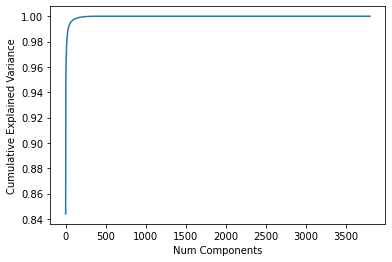

In [ ]:
plt.plot(np.cumsum(pc3.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance');

Scaling the Data

In [ ]:
#Data with only closing prices
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scale = MinMaxScaler()
array_train = scl.fit_transform(array_train)
array_test  = scale.fit_transform(array_test) #[0,1]

#Full features dataset; reducing dimensionality here
from sklearn.decomposition import PCA
pcTrain_scl = MinMaxScaler()
pcTest_scl  = MinMaxScaler()
pcaTrain = PCA(n_components = 382)
pcaTest = PCA(n_components = 382)

PCA_train = pcTrain_scl.fit_transform(PCA_train)
PCA_train = pcaTrain.fit_transform(PCA_train)

PCA_test = pcTest_scl.fit_transform(PCA_test)
PCA_test = pcaTest.fit_transform(PCA_test)

In [ ]:
print(array_train.shape)
print(PCA_train.shape)

(3804, 382)
(3804, 382)


Creating function to iteravely process data

In [ ]:
#Get the data and splits in input X and output Y, by spliting in lookback number of past days as input X 
#and horizon number of coming days as Y.
def processData(data, lookback, horizon,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -lookback - horizon +1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X),np.array(Y)

Setting lookback and horizon window sizes

In [ ]:
num_companies = df_close.shape[1]
lookback = 252 #How many days of the past can the model see
horizon = 22 #How many days into the future are we trying to predict

Further splitting the train data into training and validation sets

In [ ]:
# Formation of lookback dataframes and forward dataframes for training, and testing dataset
# to calculate accuracy

#Testing Data
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])

#Training/Validation Data
X_PCA, void = processData(PCA_train,lookback,horizon,num_companies)
void, y = processData(array_train,lookback,horizon,num_companies)
y = np.array([list(x.ravel()) for x in y])

X_train, X_validate, y_train, y_validate = train_test_split(X_PCA, y, test_size=0.20, random_state=1)

In [ ]:
8404/22
#Length y_train/test/validate / forward window == # of features

382.0

In [ ]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(2824, 252, 382)
(707, 252, 382)
(31, 252, 382)
(2824, 8404)
(707, 8404)
(31, 8404)


## Model Architecture + Training

Here, we can input the number or neurons on each layer, change the level of dropout, and set the specifications for early dropout. The model is then trained and the learning curve is plotted below.

In [ ]:
from keras.models import Sequential, load_model
import tensorflow as tf
from keras.layers import LSTM,Dense,Activation,Attention,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import Regularizer
from keras import optimizers

#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 = 800
num_neurons_L2 = 600
num_neurons_dense1 = 200
EPOCHS = 100

#Model
model = Sequential()

model.add(LSTM(num_neurons_L1,input_shape=(lookback,num_companies), return_sequences=True))
model.add(LSTM(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.add(Dense(horizon * num_companies, activation = 'relu'))
model.add(Dense(horizon * num_companies, activation = 'sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])

In [ ]:
# Early stopping severly *underfits* the data, we are going for better results

# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=11, 
#     min_delta=0.000000001, 
#     mode='max'
# )

history = model.fit(X_train,y_train,epochs=EPOCHS,
                    validation_data=(X_validate,y_validate),
                    shuffle=False,batch_size=256, verbose=2)

Epoch 1/100
12/12 - 7s - loss: 0.0430 - accuracy: 0.0011 - val_loss: 0.0168 - val_accuracy: 0.0014
Epoch 2/100
12/12 - 6s - loss: 0.0120 - accuracy: 0.0042 - val_loss: 0.0070 - val_accuracy: 0.0014
Epoch 3/100
12/12 - 6s - loss: 0.0056 - accuracy: 0.0106 - val_loss: 0.0047 - val_accuracy: 0.0057
Epoch 4/100
12/12 - 6s - loss: 0.0040 - accuracy: 0.0110 - val_loss: 0.0034 - val_accuracy: 0.0085
Epoch 5/100
12/12 - 6s - loss: 0.0030 - accuracy: 0.0117 - val_loss: 0.0027 - val_accuracy: 0.0156
Epoch 6/100
12/12 - 6s - loss: 0.0024 - accuracy: 0.0202 - val_loss: 0.0022 - val_accuracy: 0.0240
Epoch 7/100
12/12 - 6s - loss: 0.0020 - accuracy: 0.0124 - val_loss: 0.0019 - val_accuracy: 0.0156
Epoch 8/100
12/12 - 6s - loss: 0.0018 - accuracy: 0.0138 - val_loss: 0.0017 - val_accuracy: 0.0212
Epoch 9/100
12/12 - 6s - loss: 0.0016 - accuracy: 0.0188 - val_loss: 0.0015 - val_accuracy: 0.0339
Epoch 10/100
12/12 - 6s - loss: 0.0014 - accuracy: 0.0202 - val_loss: 0.0014 - val_accuracy: 0.0339
Epoch 11/

Plotting the learning curve - Loss

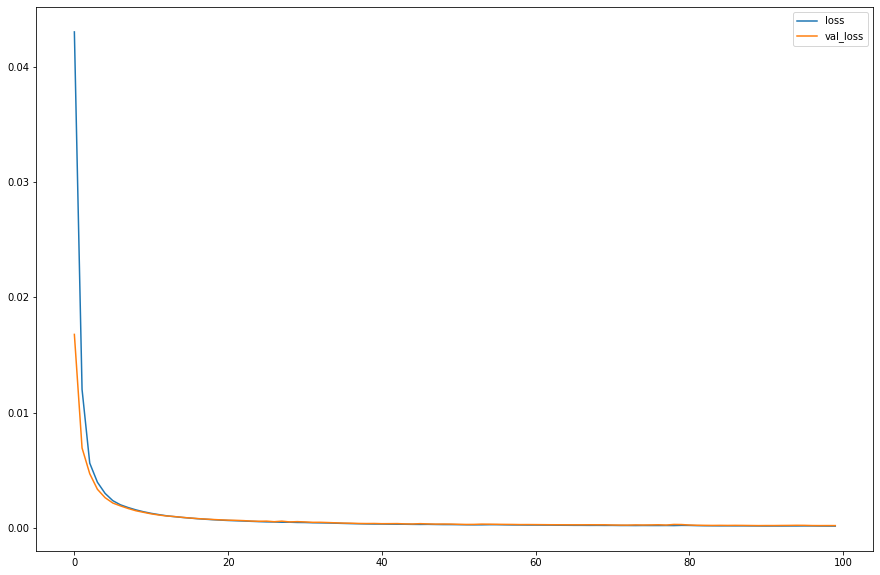

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

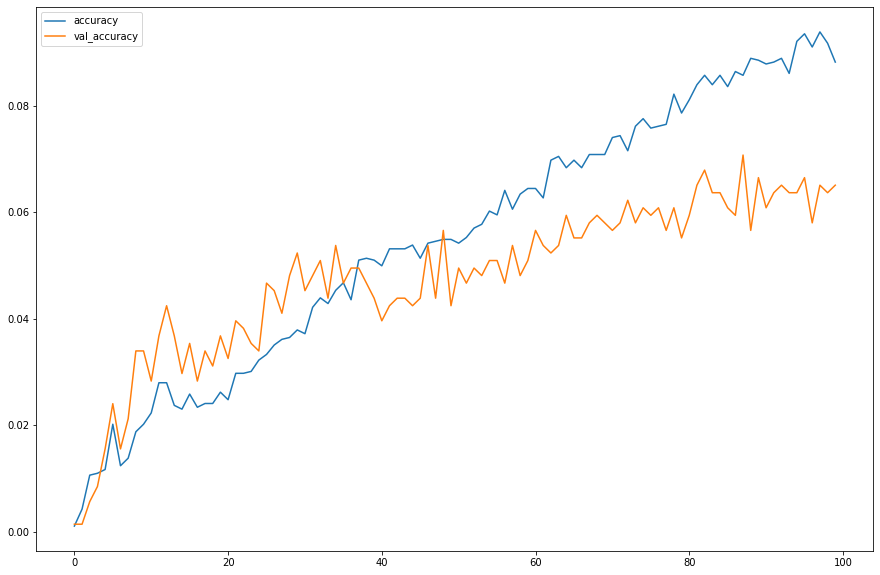

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.show()

### Predicting Test Results

In [ ]:
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])


Xt = model.predict(X_test)
Xt.shape

(31, 8404)

### Un-scaling the data and returning data to original shape
Because the results were scaled to train the model, the output is non sensible until we return the data into its original form

In [ ]:
#Aux function 1
def do_inverse_transform(output_result,num_companies):
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [ ]:
#Aux function 2
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [ ]:
#Aux function 3
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)
predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(382, 31, 22)

In [ ]:
Yt = do_inverse_transform(y_test, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(382, 682)

### Prediction Results on Test Data - Plot

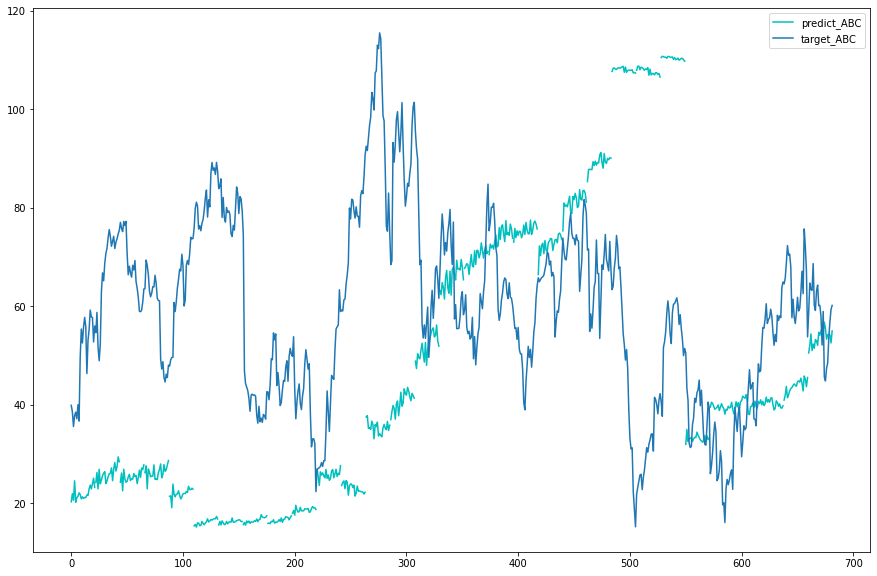

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [2] 
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'AAPL', 'ABC', 'ABMD']
 
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [ ]:
full_PCA = np.concatenate((PCA_train,PCA_test),axis = 0)

In [ ]:
X_all,void = processData(full_PCA,lookback,horizon,num_companies,horizon)
void,y_all = processData(scl.fit_transform(df_close),lookback,horizon,num_companies,horizon)
y_all = np.array([list(a.ravel()) for a in y_all])

In [ ]:
Xt = model.predict(X_all)
Xt.shape

(204, 8404)

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)

predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(382, 204, 22)

In [ ]:
Yt = do_inverse_transform(y_all, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(382, 4774)

### Prediction Results on Full Data - Plot

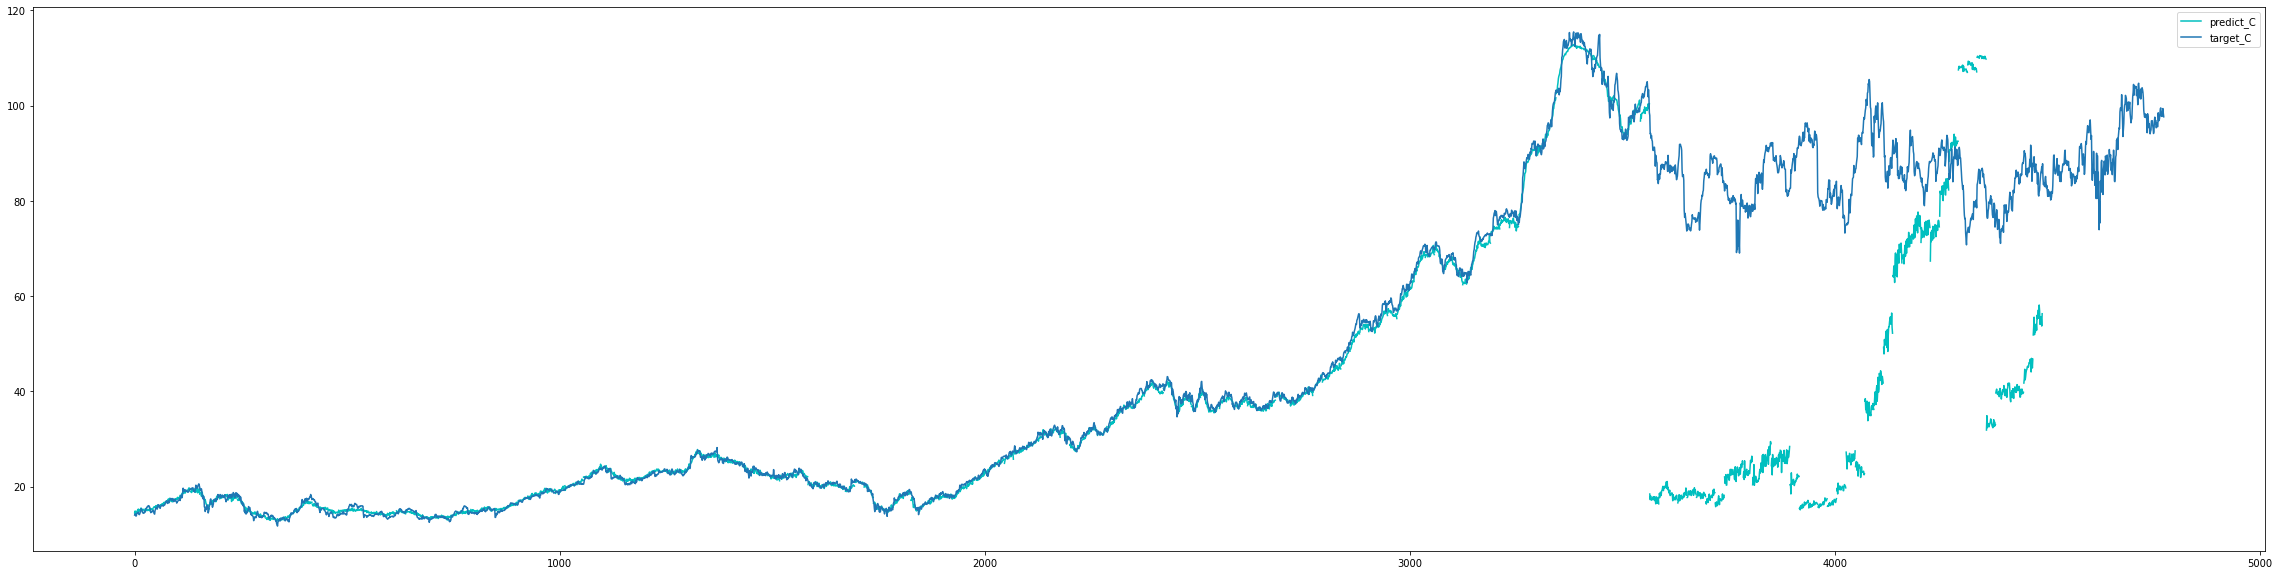

In [ ]:
plt.figure(figsize = (40,10))

companies_to_show = [2] #Type a number between 0:4 to see 4 different companies
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']

    
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

##QQ-plot

# Stock Prices Predictions

In [ ]:
predicted_prices = np.zeros((predictions.shape[1]*predictions.shape[2],predictions.shape[0]))
# actual_prices = []

for i in range(predictions.shape[0]):
  counter = 0
  for j in range(predictions.shape[1]):
    for z in range(predictions.shape[2]):
      predicted_prices[counter, i] = predictions[i,j,z]
      counter+=1

print(counter)

4488


In [ ]:
actuals_prices = actuals[:,:4488].T

In [ ]:
print(predicted_prices.shape)
print(actuals_prices.shape)
print(dates.shape)
#(lookback+1, )

(4488, 382)
(4488, 382)
(5027,)


In [ ]:
(5027-lookback+1)-4488

288

In [ ]:
# Need to remove certain days because we predict into the future. But, we aren't able to test these predicted days
# against actual days in our porfolio optimization

actual_prices = pd.DataFrame(data = actuals_prices, columns = stocks,index = dates[lookback+1:5028-287])
predicted_prices = pd.DataFrame(data = predicted_prices,columns=stocks, index = dates[lookback+1:5028-287])

In [ ]:
actual_prices

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-11-12,17.739628,0.334107,14.000000,21.750000,23.881527,14.395000,44.250000,14.470000,43.095104,8.605000,42.259998,44.540001,13.87,12.575000,1593.800049,43.150002,34.590000,4.000000,10.395000,6.382500,31.770000,4.712500,19.285000,12.390000,4.275556,56.889999,6.440000,7.120000,5.552500,34.509998,2.741667,22.640692,39.454208,5.910000,39.099998,20.940001,3.147500,46.400002,51.599998,28.631063,...,3.510000,14.150000,19.450001,15.882500,23.969999,13.455000,53.410000,20.540001,18.100000,15.678972,8.677025,9.021937,43.540001,29.461884,42.830002,26.059999,13.783259,45.128017,6.065000,38.099998,32.230000,4.070000,11.500000,25.879999,21.174999,61.709999,27.520000,24.292959,55.099998,7.142716,6.090000,51.849998,29.700001,36.029999,40.250000,14.773334,18.181818,9.149892,21.888889,48.740002
2001-11-13,17.625179,0.334821,14.197500,22.170000,24.065577,14.500000,45.310001,14.830000,43.396465,8.537500,42.070000,44.150002,14.12,12.510000,1596.000000,43.680000,33.680000,4.430000,10.425000,6.300000,31.809999,5.075000,19.480000,12.800000,4.306667,56.270000,6.300000,7.050000,5.562500,34.139999,2.813333,22.307360,38.871414,6.000000,39.410000,21.180000,3.247500,46.700001,51.009998,28.088377,...,3.450000,14.270000,20.000000,16.105000,23.900000,13.375000,53.139999,20.410000,17.969999,15.928888,8.573446,9.060786,43.720001,29.322878,43.830002,25.430000,13.783259,44.516476,6.125000,38.230000,32.480000,4.230000,11.495000,25.680000,21.309999,62.240002,27.260000,24.081009,55.580002,7.183539,6.117500,51.290001,29.389999,37.000000,40.060001,14.703333,18.102766,9.133717,22.982222,48.230000
2001-11-14,17.846924,0.345893,14.250000,22.200001,23.845615,15.335000,47.419998,14.950000,43.959541,9.005000,42.150002,44.480000,14.81,12.445000,1618.000000,44.000000,34.320000,5.100000,10.565000,6.700000,32.299999,5.425000,20.400000,13.650000,4.340741,57.990002,6.410000,7.290000,5.935000,34.840000,2.816667,22.138529,39.787235,6.065000,40.290001,21.020000,3.282500,47.630001,52.560001,28.140896,...,3.440000,14.340000,20.150000,16.237499,24.360001,13.430000,54.240002,20.500000,18.200001,16.244572,8.818268,9.117916,45.009998,29.505779,46.029999,27.150000,13.703323,43.967888,6.300000,39.040001,33.119999,4.270000,11.560000,25.709999,21.219999,63.169998,27.719999,24.610888,54.259998,7.240165,6.115000,51.770000,29.450001,38.500000,40.500000,14.683333,18.708828,9.207405,23.288889,48.099998
2001-11-15,18.104435,0.350179,13.775000,19.139999,23.423649,15.670000,46.700001,15.050000,44.284698,8.832500,41.110001,43.509998,14.94,12.505000,1624.800049,44.430000,34.139999,5.730000,10.715000,6.900000,31.650000,5.237500,20.355000,14.000000,4.481482,57.330002,7.000000,9.490000,6.062500,34.720001,2.925000,20.870131,40.536541,6.067500,41.080002,21.219999,3.167500,47.349998,53.360001,29.261278,...,3.490000,14.400000,20.500000,16.260000,24.469999,13.362500,54.230000,20.549999,18.240000,15.953003,9.169021,8.775137,44.880001,29.271666,46.750000,27.150000,13.806098,44.291645,6.345000,37.990002,34.509998,4.380000,11.210000,25.400000,21.170000,65.059998,27.219999,23.624496,55.279999,7.105844,6.140000,53.830002,28.740000,37.790001,38.700001,14.546667,18.498024,9.180446,23.040001,48.169998
2001-11-16,17.904148,0.347321,13.860000,18.070000,23.746857,15.885000,45.650002,15.060000,44.411591,8.487500,40.419998,42.950001,15.90,12.710000,1639.000000,44.990002,33.840000,5.850000,10.805000,6.727500,32.090000,5.200000,19.545000,13.750000,4.438519,57.040001,7.600000,9.050000,5.687500,34.900002,2.933333,18.982683,41.184090,6.087500,41.099998,21.049999,2.962500,47.779999,54.320000,30.101566,..

In [ ]:
predicted_prices

Index,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,...,TYL,UDR,UHS,UNH,UNM,UNP,UPS,URI,USB,VAR,VFC,VLO,VMC,VNO,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WST,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-11-12,34.723339,0.809673,14.497038,78.864876,39.810123,54.357006,75.630142,14.988930,74.004692,23.185572,59.383839,64.355278,15.679960,19.633303,1626.888672,44.576790,72.053986,8.000587,13.384463,8.076671,50.767204,5.566422,41.330734,27.597132,5.843674,80.861435,18.583511,46.441280,14.975138,65.887283,3.833019,9.249681,58.419704,9.141115,48.449726,23.696272,5.682066,49.689869,100.398384,38.187843,...,8.948623,17.720877,20.815231,24.895174,37.613483,15.952090,67.795967,34.786858,22.497307,19.956923,10.262212,9.835043,51.378246,28.683554,62.412628,44.488480,13.207806,50.336628,6.376297,56.062103,33.107044,5.617875,13.125064,25.944853,23.874815,65.136147,45.951260,23.262230,70.756660,10.059634,15.781886,52.111012,52.536892,61.483208,38.080769,15.637473,20.141737,11.422304,36.839497,47.824982
2001-11-13,35.126408,0.982565,14.849113,80.759308,40.838791,54.029518,75.654160,15.217484,74.662415,21.673079,58.451099,64.263832,15.567868,19.941881,1654.955566,45.152714,71.762802,8.710242,13.638017,7.897426,49.821995,5.093365,41.984730,29.573540,5.673889,83.068153,18.354218,46.553951,16.030113,68.154091,3.978418,8.995527,59.266151,8.478505,50.245861,23.559244,6.010471,51.610210,102.397850,39.837929,...,8.443521,17.793556,21.122971,24.207930,37.777870,16.076910,68.124290,35.282864,22.105946,20.719618,9.955426,10.359621,50.600029,28.983053,64.621941,46.099659,13.542504,49.729305,6.476966,57.692951,33.425674,5.415378,12.766225,25.845419,23.587391,67.268860,46.315571,23.324350,69.899483,9.644146,14.856400,52.487343,52.384930,64.006081,38.247784,15.423761,20.887650,11.695826,37.746418,48.347057
2001-11-14,35.044590,0.978993,14.239243,79.716850,40.172855,58.179680,75.692879,15.046624,73.408768,22.129047,59.030876,63.165234,15.717140,19.465797,1651.170532,45.002769,72.852264,8.345215,13.890152,8.008635,50.442387,5.299638,43.387409,30.236286,5.759382,83.535538,18.757286,50.401703,15.392591,68.935089,3.881742,9.050601,58.140041,8.959235,49.855129,23.494108,5.648108,50.005219,103.684441,38.555122,...,8.885585,17.802515,20.562885,25.011953,37.428020,16.028915,68.322853,36.279205,22.585583,20.335024,10.069973,10.546116,51.880322,29.277096,63.073002,43.546349,13.878524,49.900856,6.760155,55.799755,33.263985,5.640065,12.790570,25.692257,23.988895,67.572441,45.376019,23.570518,72.335335,9.832909,15.494591,53.106571,52.996742,62.726318,38.011829,15.742576,20.500156,11.267018,39.369865,48.748631
2001-11-15,35.399864,0.877615,14.769232,70.565140,40.289909,55.997494,73.692162,15.189670,74.722488,21.891279,56.579128,62.616051,15.844261,18.885368,1645.306274,45.356846,72.024368,8.027526,13.664876,7.477974,49.959534,5.255870,42.304634,29.168140,5.453367,81.843445,19.194715,50.425850,15.426743,67.798744,3.959538,8.882914,58.874546,8.909945,49.302132,23.723040,5.724741,51.178501,102.834801,38.033741,...,9.536194,17.593229,20.700727,25.110363,37.439396,16.160887,68.454704,36.238354,22.431791,20.394653,10.144908,11.161906,51.228462,28.713074,62.683956,43.437572,13.175037,49.574009,6.670278,56.516205,33.617973,5.453273,12.936710,25.929874,23.248234,67.132668,47.651890,22.703953,70.974983,10.083920,15.821898,52.761478,51.541462,62.741344,37.617390,15.962194,20.440310,12.260760,39.076553,48.542168
2001-11-16,35.487213,0.918412,14.339141,70.109032,40.855015,58.659241,73.848976,14.706191,74.970612,23.132242,57.493931,62.483326,16.092421,19.279791,1656.836060,45.501175,71.702393,8.347750,13.868706,7.731029,50.459095,4.616938,42.406757,30.105543,5.749163,80.301003,19.445366,44.014347,14.874799,68.043571,3.817299,8.687086,59.187820,8.377202,49.057

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
predicted_prices.to_csv('PCA_Predicted_Prices1.csv')
!cp PCA_Predicted_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

In [ ]:
actual_prices.to_csv('PCA_Actual_Prices1.csv')
!cp PCA_Actual_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"